In [1]:
# imports
from disperse_functions import *

### Step One: Download DisPerSE Files & Necessary Programs

To get DisPerSe running, go to https://github.com/thierry-sousbie/DisPerSE and download the files. Older versions had a few errors that needed to be fixed, but the newest version available here is good to go. 

If on a Windows device, a Linux environment is needed. I recommend WSL Ubuntu, which can be installed in Powershell with `wsl --install`, and started with `wsl ~`. After this, it will use regular bash syntax. You will have to create a venv, reinstall any packages/programs since it is a new environment, and restart your instance of this notebook through it (i.e. run `jupyter lab` after switching to WSL and then load the file, switching the kernel to your created venv).

Ensure that CMake is installed on your device, if not it can be downloaded here: https://cmake.org/download/. You will also need to have a C/C++ compiler downloaded somewhere on your device for CMake to work, I used Visual Studio build tools and made sure "C++ Cmake" was installed. 

Now, run the cell below or run the lines through your terminal (if sudo is configured with a password) and it should download the rest of the necessary libraries.

In [ ]:
%%bash
sudo apt install libcfitsio-dev -y
sudo apt install libsdl1.2-dev libsdl-image1.2-dev -y
sudo apt install libmgl-dev -y
sudo apt install libcgal-dev -y

To compile the DisPerSE build, replace the cd lines below with the pathway to your downloaded DisPerSE files. The output will be quite long; check to make sure that it gets to a 100% build, then you can clear the output of the cell. There should now be a build folder with the CMake and src files in your parent DisPerSE location.

In [ ]:
%%bash
cd /mnt/c/Users/mlaky/disperse2

rm -rf build
mkdir build
cd build

cmake ..
make -j$(nproc) 

This next cell below will also likely need to be run through terminal. If the output reaches 100%, the functions of the program can now be accessed by their names rather than the pathways, and you have a fully compiled DisPerSE build.

In [ ]:
%%bash
cd /mnt/c/Users/mlaky/disperse2/build
sudo make install

### Step Two: Run Data through DisPerSE

The important part of running your data through the program is to have everything in a properly formatted tab separated text file. For galaxies, such as the ones loaded below from the SDSS catalog, the coordinates are in right ascension, declination, and redshift, but your points can technically be in any unit as long as they are all consistent with each another. DisPerSE doesn't like headers or IDs included in 3D fields, as (in my experience) it will throw an error saying it's a 2D field instead.

There are three major functions in DisPerSE for analyzing galaxy data:

- delaunay_3D; creates a 3D delaunay tesselation based off an inputted field (ra, dec, and z in .txt file), output of a .NDfield
- mse; generates the morse-smale complex from the .NDfield, outputs another one
- skeleconv; takes the .NDfield from binary back to the readable format

which is the outline I will be using.

In the cell below, I am loading in and formatting the SDSS data I will be working with.

In [3]:
# first, importing in the data, taken from a sciserver query
sdss = Table.read("sdss_data.csv")

# getting rid of any with an invalid ID from the query, sorting and renaming columns
sdss.sort("bestObjID")
sdss = sdss[sdss["bestObjID"] != 0]
my_ID = np.arange(0, len(sdss), 1)
sdss["myID"] = my_ID # adding a simpler ID for later analysis
sdss = sdss["myID", "bestObjID", "ra", "dec", "z"]
sdss.rename_column("bestObjID", "ID")

# saving in proper format to a .txt file
sdss_radecz = sdss["ra", "dec", "z"]
with open("sdss_final.txt", "w") as f:
    f.write("ra dec z\n")
    np.savetxt(f, sdss_radecz, delimiter = "\t")

# checking that it loaded correctly
print(f"number of galaxies: {len(sdss)}")

number of galaxies: 125826


Next, we can run the calculations. Replace the "disperse_path" variable below with the pathway to the location you want the created files to output, the "filename" with the .txt file containing your data, and the "outname" with what you want to name the outputted files.

You can adjust the boundary type between "mirror", "periodic", and "void", all of which give slight variations to how the edges of the field are calculated. The significance level goes between 1 and 5, and adjust the cutoff point for determining if a pair created in the Morse-Smale Complex is statistically significant to exist as a filament. 

The "3D" in delaunay_3D can also be replaced with 2D for a 2D field, but make sure to change the inputted text file to have only x and y coordinates. The final conversion can also be adjusted depending on what format you want the output to be, such as a .vtk file. Be cognizant of the spacing in the command lines as well.

In [ ]:
# pathway
disperse_path = "/mnt/c/Users/mlaky/disperse2/"
filename = " sdss_final.txt"
outname = " sdss_run"

# delaunay tessellation
bound_type = " mirror"

delaunay_command = " delaunay_3D" + filename + " -outName" + outname + " -btype" + bound_type
print(delaunay_command)

# morse-smale complex
sig_level = "4"
fil_type = " -upSkl"

mse_command = " mse" + outname + ".NDnet" + " -outName" + outname + " -nsig " + sig_level + fil_type
print(mse_command)

# convert to readable formatting
convert = " -to NDskl_ascii -toRaDecZ"

conv_command =" skelconv" + outname + "_s" + sig_level + ".up.NDskl" + " -outName" + outname + convert
print(conv_command)

# run the commands
!cd {disperse_path}
!{delaunay_command}
!{mse_command}
!{conv_command}

### Step Three: Visualize
The next step is to visualize your outputs! These are examples of the visualizations I made of this data. The first two are of just the galaxies themselves, the second two are plots of the filaments in both 2D and 3D, and the last plot is an interactive version of the 3D plot. The functions I made simply plot the entire field, but you can adjust the viewpoint by either editing the axes of the graph shown or manually changing the functions to only plot a specific range of filaments. 

A warning if you are working with a dataset as large as mine, it may  take a while for these functions to run.

Text(0, 0.5, 'y (Mpc from center point)')

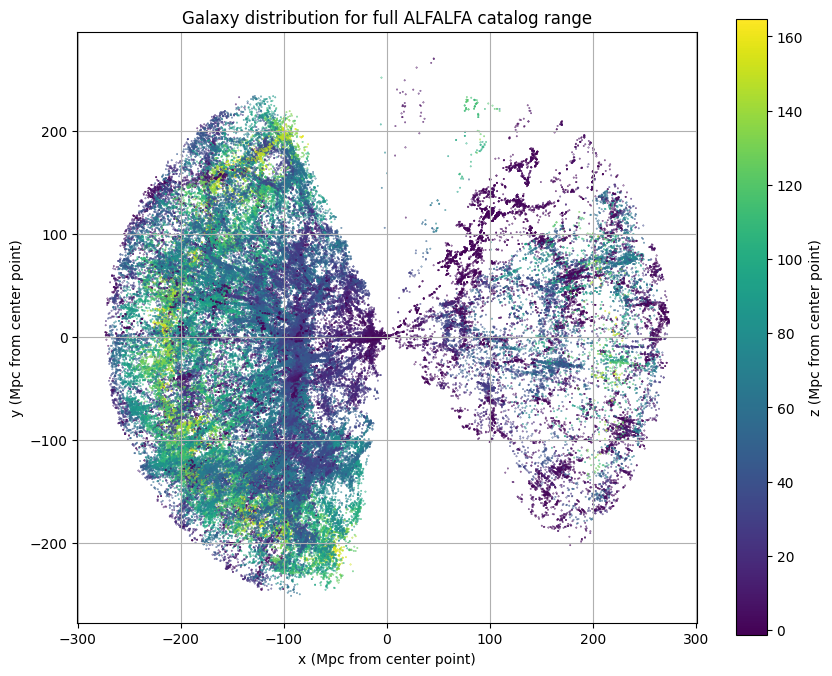

In [5]:
# first, just plotting the galaxies themselves
full_x, full_y, full_z = ra_dec_z_convert(sdss["ra"], sdss["dec"], sdss["z"])

plt.figure(figsize = (10, 8))
plt.scatter(full_x, full_y, c = full_z, s = 0.1)
plt.gca().set_aspect('equal')

plt.grid(visible = True)
plt.colorbar(label = "z (Mpc from center point)")
plt.title("Galaxy distribution for full ALFALFA catalog range")
plt.xlabel("x (Mpc from center point)")
plt.ylabel("y (Mpc from center point)")

Text(0.5, 0.92, 'Galaxy distribution for full ALFALFA catalog range')

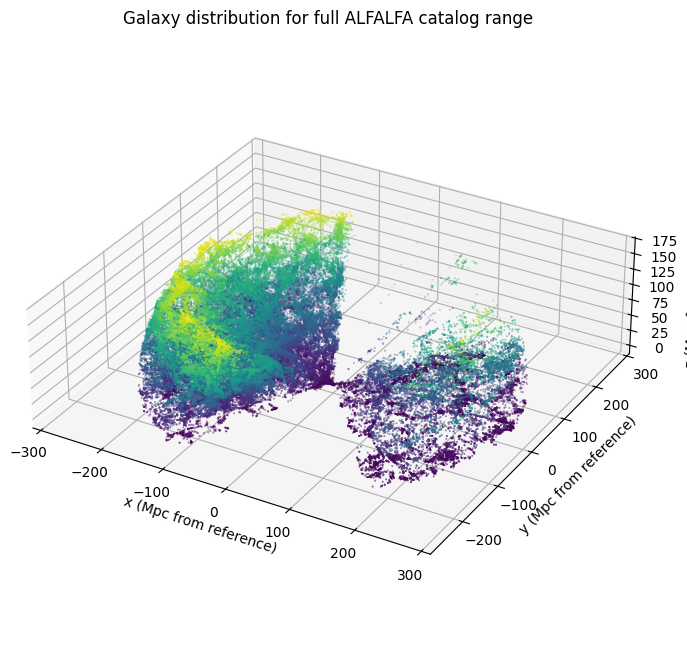

In [6]:
# again in 3d
full_x, full_y, full_z = ra_dec_z_convert(sdss["ra"], sdss["dec"], sdss["z"])

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(projection = "3d")

ax.scatter(full_x, full_y, full_z, s = 0.1, c = full_z)

ax.grid(visible = True)
ax.set_aspect("equal")

ax.set_xlabel("x (Mpc from reference)")
ax.set_ylabel("y (Mpc from reference)")
ax.set_zlabel("z (Mpc from reference)")
ax.set_title("Galaxy distribution for full ALFALFA catalog range")

Text(0.5, 1.0, 'Filaments for full ALFALFA catalog range')

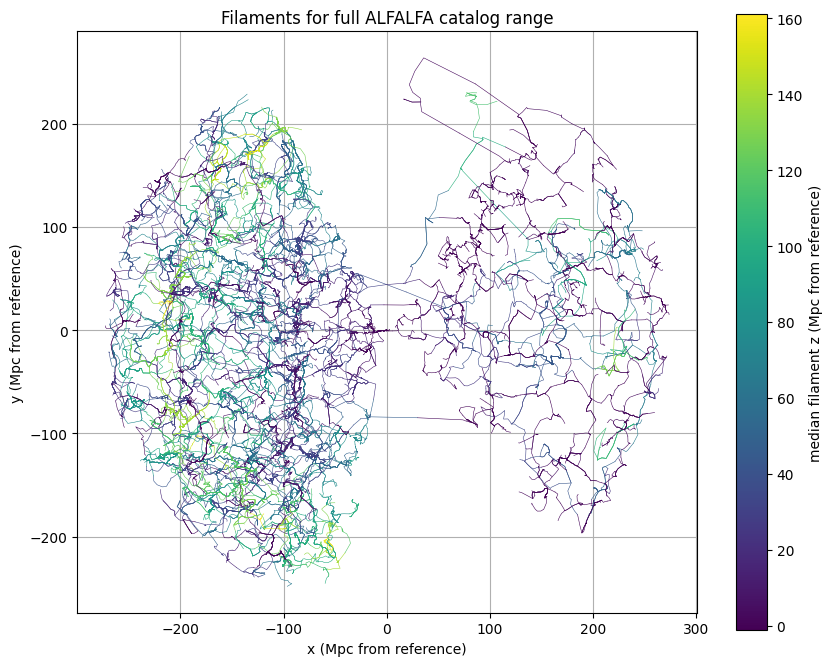

In [9]:
# filaments plotted, 2d
plot_filaments2D("runs/sdss_run.RaDecZ.a.NDskl")
plt.title("Filaments for full ALFALFA catalog range")

Text(0.5, 0.92, 'Filaments for full ALFALFA catalog range')

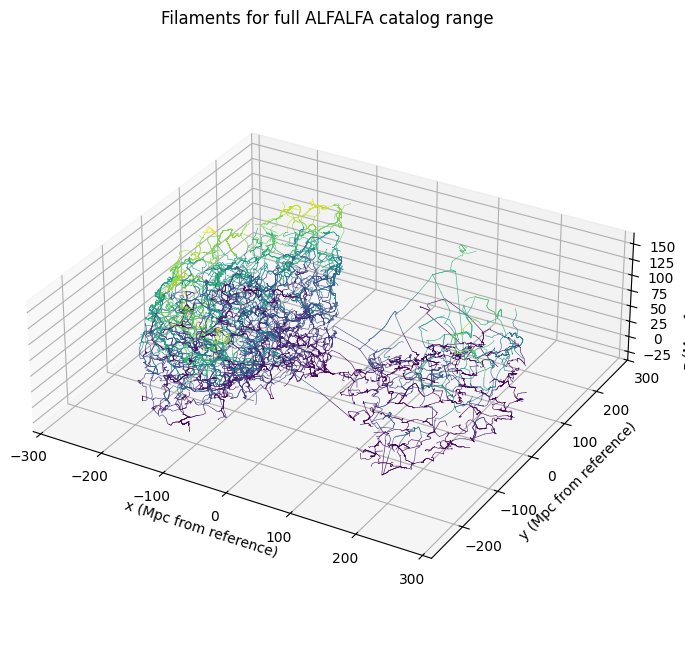

In [10]:
# filaments plotted, 3d
plot_filaments3D("runs/sdss_run.RaDecZ.a.NDskl")
plt.title("Filaments for full ALFALFA catalog range")

In [5]:
# 3d, interactive plot
# make sure both plotly and nbformat are installed
plot_filaments_interactive("runs/sdss_run.RaDecZ.a.NDskl")

### Step Four: Analysis

In [6]:
# how many filaments are in each run?
file_names = np.array(("runs/mirror1.RaDecZ.a.NDskl", "runs/mirror2.RaDecZ.a.NDskl", "runs/mirror3.RaDecZ.a.NDskl", "runs/mirror4.RaDecZ.a.NDskl", "runs/mirror5.RaDecZ.a.NDskl", 
                      "runs/periodic1.RaDecZ.a.NDskl", "runs/periodic2.RaDecZ.a.NDskl", "runs/periodic3.RaDecZ.a.NDskl", "runs/periodic4.RaDecZ.a.NDskl", "runs/periodic5.RaDecZ.a.NDskl", 
                      "runs/void1.RaDecZ.a.NDskl", "runs/void2.RaDecZ.a.NDskl", "runs/void3.RaDecZ.a.NDskl", "runs/void4.RaDecZ.a.NDskl", "runs/void5.RaDecZ.a.NDskl"))
filament_counts = []
for file in file_names:
    length = len(filaments_extract(file))
    filament_counts.append(length)

counts = np.array(filament_counts)

print(f"mirror boundary, increasing significance level: {counts[:5]}")
print(f"periodic boundary, increasing significance level: {counts[5:10]}")
print(f"void boundary, increasing significance level: {counts[10:]}")

mirror boundary, increasing significance level: [29421 15121  8336  4540  1811]
periodic boundary, increasing significance level: [29197 14978  8296  4485  1742]
void boundary, increasing significance level: [28726 14338  7599  3809  1246]


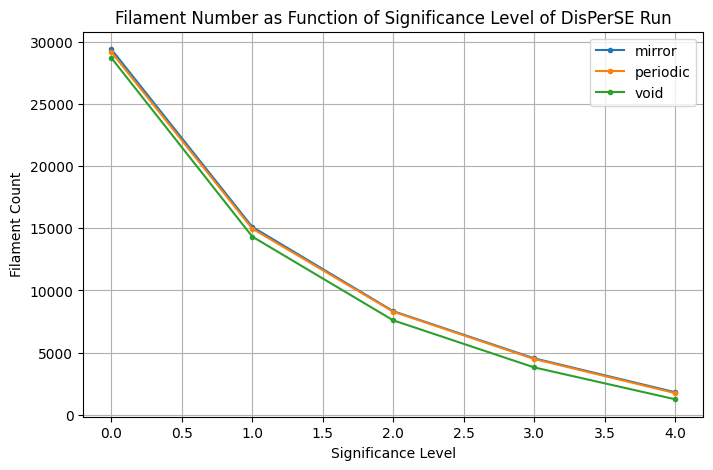

In [7]:
# line plot of filament number as function of sig level
plt.figure(figsize = (8, 5))

plt.plot(counts[:5], label = "mirror", marker = ".")
plt.plot(counts[5:10], label = "periodic", marker = ".")
plt.plot(counts[10:], label = "void", marker = ".")

plt.title("Filament Number as Function of Significance Level of DisPerSE Run")
plt.ylabel("Filament Count")
plt.xlabel("Significance Level")
plt.grid(visible = True)
plt.legend()

In [8]:
# calculating out 50% point of nearest distances array for each run
x, y, z = ra_dec_z_convert(np.array(sdss["ra"]), np.array(sdss["dec"]), np.array(sdss["z"]), reference = [0, 0, 0])
galaxy_points = np.column_stack((x, y, z))

halfway_points = []
cdfs = []

for file in file_names:
    filaments = filaments_convert(file)
    fil_distances = distances_to_filaments(galaxy_points, filaments)
    cdf = cumul_dist(fil_distances)
    halfway_point = cdf[2]

    halfway_points.append(halfway_point)
    cdfs.append(cdf)

# check that it matches the number of galaxies
points = np.array(halfway_points)
print(np.array(points))

/home/mlaky/Projects/running-disperse/disperse_functions.py:331: RuntimeWarning:

invalid value encountered in scalar divide



[0.99159293 1.26759967 1.54536368 1.87748357 2.82938242 0.98355342
 1.25823085 1.53462826 1.87456242 2.85031223 1.00273971 1.29353258
 1.59963775 2.01205327 3.23069583]


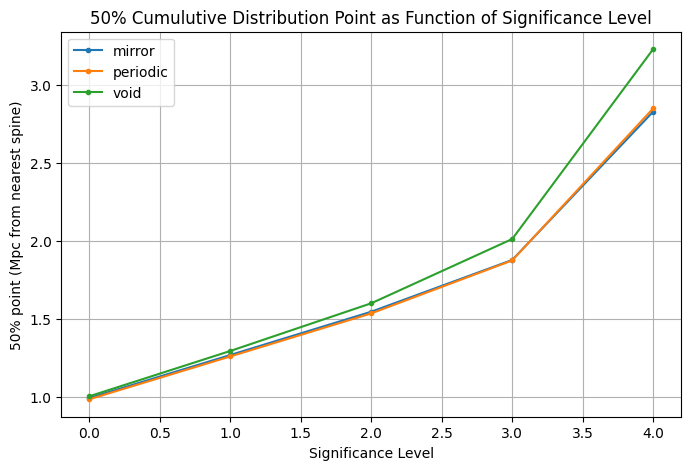

In [9]:
# line plot of 50% point as function of sig level
plt.figure(figsize = (8, 5))

plt.plot(points[:5], label = "mirror", marker = ".")
plt.plot(points[5:10], label = "periodic", marker = ".")
plt.plot(points[10:], label = "void", marker = ".")

plt.title("50% Cumulutive Distribution Point as Function of Significance Level")
plt.ylabel("50% point (Mpc from nearest spine)")
plt.xlabel("Significance Level")
plt.grid(visible = True)
plt.legend()

In [10]:
# saving best run to csv for later analysis
mirror3_dists = distances_to_filaments(galaxy_points, filaments_convert("runs/mirror3.RaDecZ.a.NDskl"))
sdss["filament distance"] = mirror3_dists
sdss.write("sdss_data_full.csv", format = "ascii.csv")